In [1]:

# basic imports
from __future__ import print_function
import numpy as np
from numpy.linalg import eig, inv
import time

# plotting elements
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib as mpl
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
cmap = cm.RdBu_r



# exptool imports
from exptool.io import psp_io
from exptool.utils import kde_3d
from exptool.observables import transform
from exptool.analysis import pattern
from exptool.analysis import trapping
from exptool.utils import *
from exptool.observables import visualize

# astropy imports
import astropy.coordinates as coord
import astropy.units as u

import scipy.interpolate as interpolate
from scipy.interpolate import UnivariateSpline
import scipy

# ipython reload capabilities for edits to external code
%load_ext autoreload
%autoreload 2


import reflexmotion as rm

from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d


In [2]:
def new_vtheta(phi,theta,vx,vy,vz):
    return np.cos(theta)*(np.cos(phi)*vx + np.sin(phi)*vy) - np.sin(theta)*vz

Text(0, 0.5, 'vtheta')

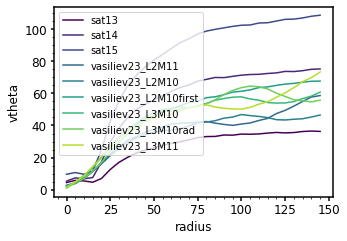

In [3]:
#
modelnums = ['erkal19','lilleengen23','erkalfixed','garavitocamargo19','sat13','sat14','sat15']

modelnums = ['erkal19','lilleengen23','erkalfixed','garavitocamargo19','vasiliev23_L2M11','vasiliev23_L2M10','vasiliev23_L2M10first','vasiliev23_L3M10','vasiliev23_L3M10rad','vasiliev23_L3M11']

modelnums = ['sat13','sat14','sat15','vasiliev23_L2M11','vasiliev23_L2M10','vasiliev23_L2M10first','vasiliev23_L3M10','vasiliev23_L3M10rad','vasiliev23_L3M11']



for im,modelnum in enumerate(modelnums):
    A = np.genfromtxt('/Users/mpetersen/OldDropbox/mike/Models_15May/sat{}_distancefits.txt'.format(modelnum),skip_header=1)
    plt.plot(A[:,0],A[:,3],label=modelnum,color=cm.viridis(im/9.,1.))



    #plt.plot(A[:,0],A[:,6],label=modelnum,color=cm.viridis(im/6.,1.))




plt.legend()

plt.xlabel('radius')
plt.ylabel('vtheta')





In [13]:
#
modelnums = ['erkal19','lilleengen23','erkalfixed','garavitocamargo19','sat13','sat14','sat15']
for im,modelnum in enumerate(modelnums):
    A = np.genfromtxt('/Users/mpetersen/OldDropbox/mike/Models_15May/sat{}_distancefits.txt'.format(modelnum),skip_header=1)
    vtheta = new_vtheta(A[:,1]*np.pi/180.,A[:,2]*np.pi/180.,A[:,7],A[:,8],A[:,9])
    
    #plt.plot(A[:,0],A[:,5],label=modelnum,color=cm.viridis(im/6.,1.))
    #plt.plot(A[:,0],vtheta+A[:,6],label=modelnum,color=cm.viridis(im/6.,1.))
    #plt.plot(A[:,0],(180./np.pi)*np.arctan2(-A[:,8],-A[:,7]) - (A[:,1]+270),label=modelnum,color=cm.viridis(im/6.,1.))
    vr = np.sqrt(A[:,7]**2+A[:,8]**2)
    bval = (180./np.pi)*np.arctan(vr/A[:,9])
    bval = (180./np.pi)*np.arccos(A[:,9]/np.sqrt(vr**2+A[:,9]**2)) - 180.
    plt.plot(A[:,0],bval,label=modelnum,color=cm.viridis(im/6.,1.))
    #plt.plot(A[:,0],90.-A[:,2],label=modelnum,color=cm.viridis(im/6.,1.))



    #plt.plot(A[:,0],A[:,6],label=modelnum,color=cm.viridis(im/6.,1.))




plt.legend()

plt.xlabel('radius')
plt.ylabel('vtheta')




NameError: name 'new_vtheta' is not defined

In [10]:
MWH = np.genfromtxt('/Volumes/External1/final_stellar_halo_1.5e11Msun_LMC.txt',skip_header=8)

xpos = MWH[:,0]
ypos = MWH[:,1]
zpos = MWH[:,2]
xvel = MWH[:,3]
yvel = MWH[:,4]
zvel = MWH[:,5]

del MWH



In [11]:
MeanDict = dict()
modelnum = 'erkalfixed'
MeanDict[modelnum] = dict()

rvals = np.sqrt(xpos*xpos + ypos*ypos + zpos*zpos)

rbins = np.arange(0.,150.,10)
rbinassignment = (np.floor(rvals/10.)).astype('int')

vtravel = np.zeros([rbins.size,3])
meanv   = np.zeros([rbins.size,3])


for indx,val in enumerate(rbins):
    w = np.where(rbinassignment==indx)[0]
    vtravel[indx] = [np.nanmedian(xvel[w]),\
                     np.nanmedian(yvel[w]),\
                     np.nanmedian(zvel[w])]
    rsnap2 = np.sqrt(xpos[w]*xpos[w]+\
                     ypos[w]*ypos[w])
    rsnap3 = np.sqrt(xpos[w]*xpos[w]+\
                     ypos[w]*ypos[w]+\
                     zpos[w]*zpos[w])
    vr = (xpos[w]*xvel[w] + ypos[w]*yvel[w] + zpos[w]*zvel[w])/rsnap3
    vtheta = ((xpos[w]*xvel[w] + ypos[w]*yvel[w])*zpos[w] -\
              rsnap2*rsnap2*zvel[w])/(rsnap2*rsnap3)
    vphi = (xpos[w]*yvel[w] - ypos[w]*xvel[w])/rsnap2
    #meanv[indx] = [np.nanmean(vr),np.nanmean(vphi),np.nanmean(vtheta)]
    meanv[indx] = [np.nanmedian(vr),np.nanmedian(vphi),np.nanmedian(vtheta)]





In [12]:

xbary = -vtravel[:,0]
ybary = -vtravel[:,1]
zbary = -vtravel[:,2]
MeanDict[modelnum]['phipos'] = np.arctan2(ybary,xbary)
#MeanDict[modelnum]['phipos'][MeanDict[modelnum]['phipos']<0] += 2*np.pi
MeanDict[modelnum]['phipos'] -= np.pi/2.
MeanDict[modelnum]['thetapos'] = np.arctan2(np.sqrt(xbary*xbary+ybary*ybary),zbary)#np.arccos(zbary/np.sqrt(xbary*xbary + ybary*ybary + zbary*zbary))
MeanDict[modelnum]['vval'] = np.sqrt(vtravel[:,0]*vtravel[:,0] + vtravel[:,1]*vtravel[:,1] + vtravel[:,2]*vtravel[:,2])
MeanDict[modelnum]['meanv'] = np.array([meanv[:,0],meanv[:,1],meanv[:,2]])
MeanDict[modelnum]['meanvcart'] = np.array([xbary,ybary,zbary])






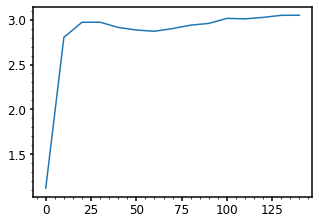

In [14]:
plt.plot(rbins,MeanDict[modelnum]['thetapos'])
#
#plt.plot((180./np.pi)*MeanDict[modelnum]['phipos'],90.-(180./np.pi)*MeanDict[modelnum]['thetapos'])
#plt.plot(rbins,90.-(180./np.pi)*MeanDict[modelnum]['thetapos'])
#plt.plot(rbins,zbary)
#plt.plot(rbins,ybary)
#plt.plot(rbins,xbary)

#plt.plot(rbins,MeanDict[modelnum]['meanv'][0])







In [16]:
modelnums = ['erkalfixed']
for modelnum in modelnums:
    f = open('/Users/mpetersen/OldDropbox/mike/Models_15May/sat{}_distancefits.txt'.format(modelnum),'w')
    
    print('radius | phi | theta | vtravel | vr | vphi | vtheta | vx | vy | vz',file=f)
    for ir,r in enumerate(rbins):
        print(r,(180./np.pi)*MeanDict[modelnum]['phipos'][ir],90.-(180./np.pi)*MeanDict[modelnum]['thetapos'][ir],\
             MeanDict[modelnum]['vval'][ir],MeanDict[modelnum]['meanv'][0][ir],MeanDict[modelnum]['meanv'][1][ir],MeanDict[modelnum]['meanv'][2][ir],\
             MeanDict[modelnum]['meanvcart'][0][ir],MeanDict[modelnum]['meanvcart'][1][ir],MeanDict[modelnum]['meanvcart'][2][ir],file=f)
        
    f.close()




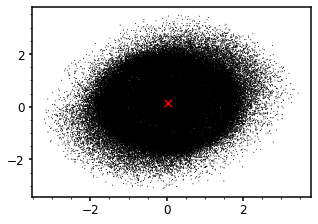

In [26]:

plt.scatter(MWD.data['vx'][:100000],MWD.data['vy'][:100000],edgecolor='none',facecolor='black',s=1.)
plt.scatter(np.nanmedian(MWD.data['vx']),np.nanmedian(MWD.data['vy']),marker='x',color='red',s=50.)



In [104]:

inputfile = '/Volumes/External1/OUT.run9mlde.00012'
modelnum = 'lilleengen23'


try:
    MWD = psp_io.Input(inputfile,'disc')
    MWH = psp_io.Input(inputfile,'mw')
except:
    MWD = psp_io.Input(inputfile,'star')
    MWH = psp_io.Input(inputfile,'dark')

rscale = 282.
vscale = (190./1.4)

revz = 1.
xpos = rscale*(MWH.data['x']       - np.nanmedian(MWD.data['x']))
ypos = rscale*(MWH.data['y']       - np.nanmedian(MWD.data['y']))
zpos = revz*rscale*(MWH.data['z']  - np.nanmedian(MWD.data['z']))
xvel = vscale*(MWH.data['vx']      - np.nanmedian(MWD.data['vx']))
yvel = vscale*(MWH.data['vy']      - np.nanmedian(MWD.data['vy']))
zvel = revz*vscale*(MWH.data['vz'] - np.nanmedian(MWD.data['vz']))



In [105]:
rlimitmin = 40
rlimitmax = 80

rposhalo = np.linalg.norm(np.c_[xpos,ypos,zpos],axis=1)
w = np.where((rposhalo > rlimitmin) & (rposhalo < rlimitmax))
print(w[0].size)

for quantity in [xpos,ypos,zpos,xvel,yvel,zvel]:
    print(np.nanmedian(quantity[w]))

327612
-0.12049246
1.3738708
-15.018635
-0.31174088
8.2759075
-15.98386


In [106]:
counter = 0

xoffset,yoffset,zoffset,xveloffset,yveloffset,zveloffset = 0.0,0.0,0.0,0.0,0.0,0.0

In [113]:

counter +=1

xoffset -= np.nanmedian(xpos[w])
yoffset -= np.nanmedian(ypos[w])
zoffset -= np.nanmedian(zpos[w])
xveloffset -= np.nanmedian(xvel[w])
yveloffset -= np.nanmedian(yvel[w])
zveloffset -= np.nanmedian(zvel[w])

xpos = xpos - np.nanmedian(xpos[w])
ypos = ypos - np.nanmedian(ypos[w])
zpos = zpos - np.nanmedian(zpos[w])
xvel = xvel - np.nanmedian(xvel[w])
yvel = yvel - np.nanmedian(yvel[w])
zvel = zvel - np.nanmedian(zvel[w])


for quantity in [xpos,ypos,zpos,xvel,yvel,zvel]:
    print(np.nanmedian(quantity[w]))

rposhalo = np.linalg.norm(np.c_[xpos,ypos,zpos],axis=1)
w = np.where((rposhalo > rlimitmin) & (rposhalo < rlimitmax))
print(w[0].size)

for quantity in [xpos,ypos,zpos,xvel,yvel,zvel]:
    print(np.nanmedian(quantity[w]))
    
print(xoffset,yoffset,zoffset,xveloffset,yveloffset,zveloffset)

0.0
0.0
0.0
0.0
0.0
0.0
325408
-0.00025265664
-0.006427169
0.005610466
0.013075203
0.00060749054
-0.001534462
0.1483185514807701 -1.0976356267929077 12.09034538269043 0.5727364420890808 -6.994988918304443 14.712077617645264


In [102]:
xpos = rscale*(MWH.data['x'])       + xoffset
ypos = rscale*(MWH.data['y'])       + yoffset
zpos = revz*rscale*(MWH.data['z'])  + zoffset
xvel = vscale*(MWH.data['vx'])      + xveloffset
yvel = vscale*(MWH.data['vy'])      + yveloffset
zvel = revz*vscale*(MWH.data['vz']) + zveloffset

rposhalo = np.linalg.norm(np.c_[xpos,ypos,zpos],axis=1)
w = np.where((rposhalo > rlimitmin) & (rposhalo < rlimitmax))

for quantity in [xpos,ypos,zpos,xvel,yvel,zvel]:
    print(np.nanmedian(quantity[w]))


3.810651
26.965
0.9244709
2.898015
-7.417156
5.1899624


In [65]:

xposcen = xpos - np.nanmedian(xpos[w])
yposcen = ypos - np.nanmedian(ypos[w])
zposcen = zpos - np.nanmedian(zpos[w])
xvelcen = xvel - np.nanmedian(xvel[w])
yvelcen = yvel - np.nanmedian(yvel[w])
zvelcen = zvel - np.nanmedian(zvel[w])


for quantity in [xposcen,yposcen,zposcen,xvelcen,yvelcen,zvelcen]:
    print(np.nanmedian(quantity[w]))


rposhalocen = np.linalg.norm(np.c_[xposcen,yposcen,zposcen],axis=1)
w = np.where((rposhalocen > rlimitmin) & (rposhalocen < rlimitmax))
for quantity in [xposcen,yposcen,zposcen,xvelcen,yvelcen,zvelcen]:
    print(np.nanmedian(quantity[w]))


0.0
0.0
0.0
0.0
0.0
0.0
-0.65663135
-0.47547185
6.7130814
0.3511464
-1.2810602
0.64872074


In [114]:

rsnap2 = np.sqrt(xposcen[w]*xposcen[w]+\
                 yposcen[w]*yposcen[w])
rsnap3 = np.sqrt(xposcen[w]*xposcen[w]+\
                 yposcen[w]*yposcen[w]+\
                 zposcen[w]*zposcen[w])
vr = (xposcen[w]*xvelcen[w] + yposcen[w]*yvelcen[w] + zposcen[w]*zvelcen[w])/rsnap3
vtheta = ((xposcen[w]*xvelcen[w] + yposcen[w]*yvelcen[w])*zposcen[w] -\
          rsnap2*rsnap2*zvel[w])/(rsnap2*rsnap3)
vphi = (xposcen[w]*yvelcen[w] - yposcen[w]*xvelcen[w])/rsnap2

print(np.nanmedian(vr),np.nanmedian(vtheta),np.nanmedian(vphi))

0.79065263 -3.885219 0.03083062


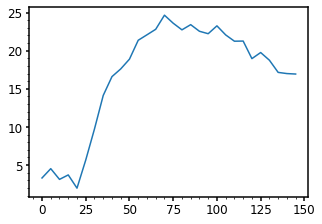

In [13]:
#MeanDict = dict()


inputfile = '/Volumes/External1/OUT.run26mldf.00019'
modelnum = 'erkal19'

#inputfile = '/Volumes/External1/OUT.run9mlde.00012'
#modelnum = 'lilleengen23'

#inputfile = '/Volumes/SIMSET/Disk065/OUT.run065s13n.00098'
#modelnum = 'sat13'

#inputfile = '/Volumes/SIMSET/Disk065/OUT.run065s14n.00097'
#inputfile = '/Users/mpetersen/Downloads/OUT.run065s14n.00097'
#modelnum = 'sat14'

#inputfile = '/Volumes/SIMSET/Disk065/OUT.run065s15n.00095'
#modelnum = 'sat15'

try:
    MWD = psp_io.Input(inputfile,'disc')
    MWH = psp_io.Input(inputfile,'mw')
except:
    MWD = psp_io.Input(inputfile,'star')
    MWH = psp_io.Input(inputfile,'dark')


rscale = 195.
vscale = (184./1.4)

rscale = 282.
vscale = (190./1.4)

if modelnum in ['sat13','sat14','sat15']:
    revz = -1.
    print('reversing...')
else:
    revz = -1.

xpos = rscale*(MWH.data['x']-np.nanmedian(MWD.data['x']))
ypos = rscale*(MWH.data['y']-np.nanmedian(MWD.data['y']))
zpos = revz*rscale*(MWH.data['z']-np.nanmedian(MWD.data['z']))
xvel = vscale*(MWH.data['vx']-np.nanmedian(MWD.data['vx']))
yvel = vscale*(MWH.data['vy']-np.nanmedian(MWD.data['vy']))
zvel = revz*vscale*(MWH.data['vz']-np.nanmedian(MWD.data['vz']))


MeanDict[modelnum] = dict()

rvals = np.sqrt(xpos*xpos + ypos*ypos + zpos*zpos)

rbins = np.arange(0.,150.,5)
rbinassignment = (np.floor(rvals/10.)).astype('int')

vtravel = np.zeros([rbins.size,3])
meanv   = np.zeros([rbins.size,3])


for indx,val in enumerate(rbins):
    w = np.where(rbinassignment==indx)[0]
    vtravel[indx] = [np.nanmedian(xvel[w]),\
                     np.nanmedian(yvel[w]),\
                     np.nanmedian(zvel[w])]
    rsnap2 = np.sqrt(xpos[w]*xpos[w]+\
                     ypos[w]*ypos[w])
    rsnap3 = np.sqrt(xpos[w]*xpos[w]+\
                     ypos[w]*ypos[w]+\
                     zpos[w]*zpos[w])
    vr = (xpos[w]*xvel[w] + ypos[w]*yvel[w] + zpos[w]*zvel[w])/rsnap3
    vtheta = ((xpos[w]*xvel[w] + ypos[w]*yvel[w])*zpos[w] -\
              rsnap2*rsnap2*zvel[w])/(rsnap2*rsnap3)
    vphi = (xpos[w]*yvel[w] - ypos[w]*xvel[w])/rsnap2
    #meanv[indx] = [np.nanmean(vr),np.nanmean(vphi),np.nanmean(vtheta)]
    meanv[indx] = [np.nanmedian(vr),np.nanmedian(vphi),np.nanmedian(vtheta)]



xbary = -vtravel[:,0]
ybary = -vtravel[:,1]
zbary = -vtravel[:,2]
MeanDict[modelnum]['phipos'] = np.arctan2(ybary,xbary)
#MeanDict[modelnum]['phipos'][MeanDict[modelnum]['phipos']<0] += 2*np.pi

if modelnum in ['sat13','sat14','sat15']:
    MeanDict[modelnum]['phipos'] -= np.pi/2. # only if the satellite series, right?
    print('twisting...')


MeanDict[modelnum]['thetapos'] = np.arctan2(np.sqrt(xbary*xbary+ybary*ybary),zbary)#np.arccos(zbary/np.sqrt(xbary*xbary + ybary*ybary + zbary*zbary))
MeanDict[modelnum]['vval'] = np.sqrt(vtravel[:,0]*vtravel[:,0] + vtravel[:,1]*vtravel[:,1] + vtravel[:,2]*vtravel[:,2])
MeanDict[modelnum]['meanv'] = np.array([meanv[:,0],meanv[:,1],meanv[:,2]])
MeanDict[modelnum]['meanvcart'] = np.array([xbary,ybary,zbary])



plt.plot(rbins,MeanDict[modelnum]['vval'])




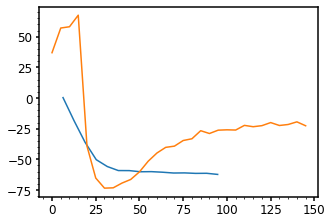

In [14]:
A = np.genfromtxt("/Users/mpetersen/OldDropbox/mike/Models_20April/s14_shells_displacement.txt",skip_header=1)
rpos,tvel,xvel,yvel,zvel = A[:,0],A[:,1],A[:,2],A[:,3],-A[:,4]


thetapos = np.arctan2(np.sqrt(xvel**2 + yvel**2),zvel)
plt.plot(A[:,0],90-(180./np.pi)*thetapos)

plt.plot(rbins,90-(180/np.pi)*MeanDict[modelnum]['thetapos'])




In [24]:
del(MWD,MWH)

ValueError: x and y must have same first dimension, but have shapes (30,) and (15,)

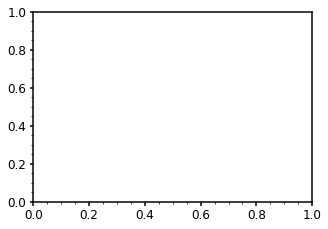

In [21]:
#
#modelnums = ['erkal19','lilleengen23']#,'erkalfixed','garavitocamargo19',
modelnums = ['sat13','sat14','sat15']
for im,modelnum in enumerate(modelnums):
    #plt.plot(rbins,MeanDict[modelnum]['meanvcart'][1],label=modelnum,color=cm.viridis(im/6.,1.))
    plt.plot(rbins,MeanDict[modelnum]['meanv'][2],label=modelnum,color=cm.viridis(im/6.,1.))
    #plt.plot(rbins,MeanDict[modelnum]['thetapos'],label=modelnum,color=cm.viridis(im/6.,1.))


plt.legend()

plt.xlabel('radius')
plt.ylabel('reflex signal')



In [15]:
modelnums = ['erkal19','lilleengen23','erkalfixed','garavitocamargo19','sat13','sat14','sat15']

modelnums = ['sat13','sat14','sat15']
modelnums = ['erkal19','lilleengen23']

for modelnum in modelnums:
    f = open('/Users/mpetersen/OldDropbox/mike/Models_15May/sat{}_distancefits.txt'.format(modelnum),'w')
    
    print('radius | phi | theta | vtravel | vr | vphi | vtheta | vx | vy | vz',file=f)
    for ir,r in enumerate(rbins):
        print(r,(180./np.pi)*MeanDict[modelnum]['phipos'][ir],90.-(180./np.pi)*MeanDict[modelnum]['thetapos'][ir],\
             MeanDict[modelnum]['vval'][ir],MeanDict[modelnum]['meanv'][0][ir],MeanDict[modelnum]['meanv'][1][ir],MeanDict[modelnum]['meanv'][2][ir],\
             MeanDict[modelnum]['meanvcart'][0][ir],MeanDict[modelnum]['meanvcart'][1][ir],MeanDict[modelnum]['meanvcart'][2][ir],file=f)
        
    f.close()





In [17]:
GC19 = np.load("/Volumes/External1/MWLMC5_pos_vel_DM_halo.npy")

In [18]:
GC19.shape

(3, 100000000, 2)

In [19]:

modelnum = 'garavitocamargo19'


xpos = GC19[0,:,0]
ypos = GC19[1,:,0]
zpos = GC19[2,:,0]
xvel = GC19[0,:,1]
yvel = GC19[1,:,1]
zvel = GC19[2,:,1]

MeanDict[modelnum] = dict()

rvals = np.sqrt(xpos*xpos + ypos*ypos + zpos*zpos)

rbins = np.arange(0.,150.,10)
rbinassignment = (np.floor(rvals/10.)).astype('int')

vtravel = np.zeros([rbins.size,3])
meanv   = np.zeros([rbins.size,3])


for indx,val in enumerate(rbins):
    w = np.where(rbinassignment==indx)[0]
    vtravel[indx] = [np.nanmedian(xvel[w]),\
                     np.nanmedian(yvel[w]),\
                     np.nanmedian(zvel[w])]
    rsnap2 = np.sqrt(xpos[w]*xpos[w]+\
                     ypos[w]*ypos[w])
    rsnap3 = np.sqrt(xpos[w]*xpos[w]+\
                     ypos[w]*ypos[w]+\
                     zpos[w]*zpos[w])
    vr = (xpos[w]*xvel[w] + ypos[w]*yvel[w] + zpos[w]*zvel[w])/rsnap3
    vtheta = ((xpos[w]*xvel[w] + ypos[w]*yvel[w])*zpos[w] -\
              rsnap2*rsnap2*zvel[w])/(rsnap2*rsnap3)
    vphi = (xpos[w]*yvel[w] - ypos[w]*xvel[w])/rsnap2
    #meanv[indx] = [np.nanmean(vr),np.nanmean(vphi),np.nanmean(vtheta)]
    meanv[indx] = [np.nanmedian(vr),np.nanmedian(vphi),np.nanmedian(vtheta)]






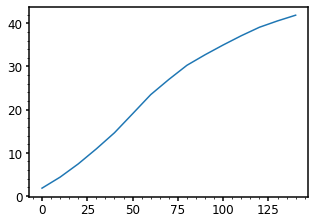

In [20]:

xbary = -vtravel[:,0]
ybary = -vtravel[:,1]
zbary = -vtravel[:,2]
MeanDict[modelnum]['phipos'] = np.arctan2(ybary,xbary)
#MeanDict[modelnum]['phipos'][MeanDict[modelnum]['phipos']<0] += 2*np.pi
MeanDict[modelnum]['phipos'] -= np.pi/2.
MeanDict[modelnum]['thetapos'] = np.arctan2(np.sqrt(xbary*xbary+ybary*ybary),zbary)#np.arccos(zbary/np.sqrt(xbary*xbary + ybary*ybary + zbary*zbary))
MeanDict[modelnum]['vval'] = np.sqrt(vtravel[:,0]*vtravel[:,0] + vtravel[:,1]*vtravel[:,1] + vtravel[:,2]*vtravel[:,2])
MeanDict[modelnum]['meanv'] = np.array([meanv[:,0],meanv[:,1],meanv[:,2]])
MeanDict[modelnum]['meanvcart'] = np.array([xbary,ybary,zbary])



plt.plot(rbins,MeanDict[modelnum]['vval'])



In [21]:
modelnums = ['garavitocamargo19']

for modelnum in modelnums:
    f = open('/Users/mpetersen/OldDropbox/mike/Models_15May/sat{}_distancefits.txt'.format(modelnum),'w')
    
    print('radius | phi | theta | vtravel | vr | vphi | vtheta | vx | vy | vz',file=f)
    for ir,r in enumerate(rbins):
        print(r,(180./np.pi)*MeanDict[modelnum]['phipos'][ir],90.-(180./np.pi)*MeanDict[modelnum]['thetapos'][ir],\
             MeanDict[modelnum]['vval'][ir],MeanDict[modelnum]['meanv'][0][ir],MeanDict[modelnum]['meanv'][1][ir],MeanDict[modelnum]['meanv'][2][ir],\
             MeanDict[modelnum]['meanvcart'][0][ir],MeanDict[modelnum]['meanvcart'][1][ir],MeanDict[modelnum]['meanvcart'][2][ir],file=f)
        
    f.close()






In [30]:
V23 = np.load("/Volumes/External1/Vasiliev23/L2M11/snapshot.npz")

print(V23['pos'].shape)

#   The first Nlmc = 2e6 particles represent the Magellanic system, the next 7e6
#  represent the MW halo, and the remaining 1e6 represent the stellar disc+bulge;
#  all particles from the same category have identical masses.

(10000000, 3)


In [29]:
V23['pos']#[2000000:9000000,0]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [70]:

V23 = np.load("/Volumes/External1/Vasiliev23/L2M11/snapshot.npz")
modelnum = 'vasiliev23_L2M11'

#V23 = np.load("/Volumes/External1/Vasiliev23/L2M10/snapshot.npz")
#modelnum = 'vasiliev23_L2M10'

#V23 = np.load("/Volumes/External1/Vasiliev23/L2M10first/snapshot.npz")
#modelnum = 'vasiliev23_L2M10first'

#V23 = np.load("/Volumes/External1/Vasiliev23/L3M10/snapshot.npz")
#modelnum = 'vasiliev23_L3M10'

#V23 = np.load("/Volumes/External1/Vasiliev23/L3M10rad/snapshot.npz")
#modelnum = 'vasiliev23_L3M10rad'

#V23 = np.load("/Volumes/External1/Vasiliev23/L3M11/snapshot.npz")
#modelnum = 'vasiliev23_L3M11'

xpos = V23['pos'][2000000:9000000,0]
ypos = V23['pos'][2000000:9000000,1]
zpos = V23['pos'][2000000:9000000,2]
xvel = V23['vel'][2000000:9000000,0]
yvel = V23['vel'][2000000:9000000,1]
zvel = V23['vel'][2000000:9000000,2]

MeanDict[modelnum] = dict()

rvals = np.sqrt(xpos*xpos + ypos*ypos + zpos*zpos)

rbins = np.arange(0.,150.,5)
rbinassignment = (np.floor(rvals/10.)).astype('int')

vtravel = np.zeros([rbins.size,3])
meanv   = np.zeros([rbins.size,3])


for indx,val in enumerate(rbins):
    w = np.where(rbinassignment==indx)[0]
    vtravel[indx] = [np.nanmedian(xvel[w]),\
                     np.nanmedian(yvel[w]),\
                     np.nanmedian(zvel[w])]
    rsnap2 = np.sqrt(xpos[w]*xpos[w]+\
                     ypos[w]*ypos[w])
    rsnap3 = np.sqrt(xpos[w]*xpos[w]+\
                     ypos[w]*ypos[w]+\
                     zpos[w]*zpos[w])
    vr = (xpos[w]*xvel[w] + ypos[w]*yvel[w] + zpos[w]*zvel[w])/rsnap3
    vtheta = ((xpos[w]*xvel[w] + ypos[w]*yvel[w])*zpos[w] -\
              rsnap2*rsnap2*zvel[w])/(rsnap2*rsnap3)
    vphi = (xpos[w]*yvel[w] - ypos[w]*xvel[w])/rsnap2
    #meanv[indx] = [np.nanmean(vr),np.nanmean(vphi),np.nanmean(vtheta)]
    meanv[indx] = [np.nanmedian(vr),np.nanmedian(vphi),np.nanmedian(vtheta)]




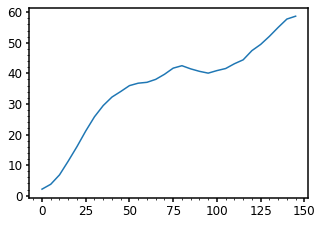

In [71]:

xbary = -vtravel[:,0]
ybary = -vtravel[:,1]
zbary = -vtravel[:,2]
MeanDict[modelnum]['phipos'] = np.arctan2(ybary,xbary)
#MeanDict[modelnum]['phipos'][MeanDict[modelnum]['phipos']<0] += 2*np.pi
MeanDict[modelnum]['phipos'] -= np.pi/2.
MeanDict[modelnum]['thetapos'] = np.arctan2(np.sqrt(xbary*xbary+ybary*ybary),zbary)#np.arccos(zbary/np.sqrt(xbary*xbary + ybary*ybary + zbary*zbary))
MeanDict[modelnum]['vval'] = np.sqrt(vtravel[:,0]*vtravel[:,0] + vtravel[:,1]*vtravel[:,1] + vtravel[:,2]*vtravel[:,2])
MeanDict[modelnum]['meanv'] = np.array([meanv[:,0],meanv[:,1],meanv[:,2]])
MeanDict[modelnum]['meanvcart'] = np.array([xbary,ybary,zbary])



plt.plot(rbins,MeanDict[modelnum]['vval'])




In [72]:
modelnums = [modelnum]

for modelnum in modelnums:
    f = open('/Users/mpetersen/OldDropbox/mike/Models_15May/sat{}_distancefits.txt'.format(modelnum),'w')
    
    print('radius | phi | theta | vtravel | vr | vphi | vtheta | vx | vy | vz',file=f)
    for ir,r in enumerate(rbins):
        print(r,(180./np.pi)*MeanDict[modelnum]['phipos'][ir],90.-(180./np.pi)*MeanDict[modelnum]['thetapos'][ir],\
             MeanDict[modelnum]['vval'][ir],MeanDict[modelnum]['meanv'][0][ir],MeanDict[modelnum]['meanv'][1][ir],MeanDict[modelnum]['meanv'][2][ir],\
             MeanDict[modelnum]['meanvcart'][0][ir],MeanDict[modelnum]['meanvcart'][1][ir],MeanDict[modelnum]['meanvcart'][2][ir],file=f)
        
    f.close()







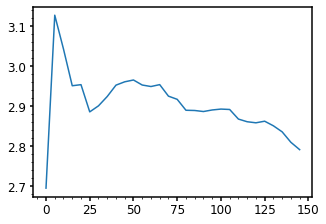

In [73]:
plt.plot(rbins,MeanDict[modelnum]['thetapos'])



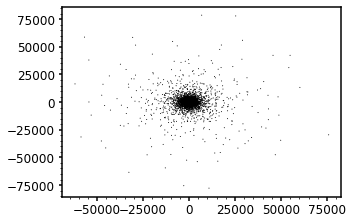

In [23]:
plt.scatter(GC19[0,::1000,0],GC19[1,::1000,0],edgecolor='none',facecolor='black',s=1.)


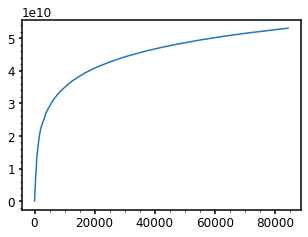

In [28]:
rvals = np.linalg.norm(GC19[:,:,0],axis=0)
rcum = rvals[rvals.argsort()]
mcum = np.cumsum(rvals[rvals.argsort()])




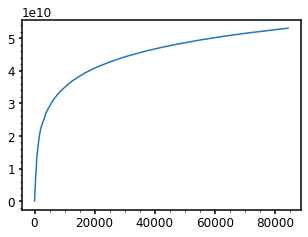

In [30]:
plt.plot(rcum[::1000],mcum[::1000])



In [2]:
# see https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu3ast/sec_cu3ast_intro/ssec_cu3ast_intro_tansforms.html


def return_gaia_Agprime():
    """return the matrix in eq 3.61, key to transform from ICRS to galactic coordinates"""
    return np.array([[-0.0548755604162154,-0.8734370902348850,-0.4838350155487132],
                     [+0.4941094278755837,-0.4448296299600112,+0.7469822444972189],
                     [-0.8676661490190047,-0.1980763734312015,+0.4559837761750669]])

def return_ricrs(a,d):
    """ eq. 3.57"""
    return np.array([np.cos(a)*np.cos(d),np.sin(a)*np.cos(d),np.sin(d)]).T

def return_picrs(a,d):
    """ eq. 3.64, unit vector of increasing alpha"""
    return np.array([-np.sin(a),np.cos(a),0.]).T

def return_qicrs(a,d):
    """ eq. 3.64, unit vector of increasing delta"""
    return np.array([-np.cos(a)*np.sin(d),-np.sin(a)*np.sin(d),np.cos(d)]).T

def return_muicrs(a,d,mua,mud):
    """ eq. 3.66, the proper motion vector"""
    p = return_picrs(a,d)
    q = return_qicrs(a,d)
    return np.dot(p,mua) + np.dot(q,mud)


def return_rgal(l,b):
    """ eq. 3.58"""
    return np.array([np.cos(l)*np.cos(b),np.sin(l)*np.cos(b),np.sin(b)]).T

def return_pgal(l,b):
    """ eq. 3.66, unit vector of increasing alpha"""
    return np.array([-np.sin(l),np.cos(l),0.]).T

def return_qgal(l,b):
    """ eq. 3.66, unit vector of increasing delta"""
    return np.array([-np.cos(l)*np.sin(b),-np.sin(l)*np.sin(b),np.cos(b)]).T

def return_mugal(l,b,mul,mub):
    """ eq. 3.66, the proper motion vector"""
    p = return_pgal(l,b)
    q = return_qgal(l,b)
    return np.dot(p,mul) + np.dot(q,mub)


def rotate_velocities(a,d,mua,mud):
    """eq 3.68, """
    mu = return_muicrs(a,d,mua,mud)
    mugal = np.dot(return_gaia_Agprime(),mu) # eq. 3.68
    
    # solve for positions
    ricrs = return_ricrs(a,d)
    rgal = np.dot(return_gaia_Agprime(),ricrs)

    # implement eq 3.63
    ell,b = np.arctan2(rgal[1],rgal[0]),np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))
    
    p = return_pgal(ell,b)
    q = return_qgal(ell,b)
    
    mul = np.dot(p.T,mugal)
    mub = np.dot(q.T,mugal)
    #print(mul,mub)
    return mul,mub



def rotate_errors(a,d,pmra_e,pmdec_e,pmcorr):
    ricrs = return_ricrs(a,d)
    picrs = return_picrs(a,d)
    qicrs = return_qicrs(a,d)

    rgal = np.dot(return_gaia_Agprime(),ricrs)

    # implement eq 3.63
    ell = np.arctan2(rgal[1],rgal[0])
    b = np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))

    pgal = return_pgal(ell,b)
    qgal = return_qgal(ell,b)

    pqgal = np.stack((pgal, qgal), axis=-1)
    pqicrs = np.stack((picrs, qicrs), axis=-1)

    cov = np.array([[pmra_e*pmra_e,pmra_e*pmdec_e*pmcorr],[pmra_e*pmdec_e*pmcorr,pmdec_e*pmdec_e]])
    #print(cov)

    G = np.einsum('ab,ac->bc', pqgal,
                      np.einsum('ji,ik->jk', return_gaia_Agprime(), pqicrs))

    cov_to = np.einsum('ba,ac->bc', G,
                           np.einsum('ij,ki->jk', cov, G))
    
    return cov_to

#print(G)

def rotate_positions(a,d,dist):
    """eq 3.68, """
    # solve for positions
    ricrs = return_ricrs(a,d)
    rgal = np.dot(return_gaia_Agprime(),ricrs)
    return dist*rgal



    
    
a = 45.*np.pi/180.
d = 60.*np.pi/180.

mua = 1.
mud = -1.

#print(return_muicrs(a,d,mua,mud))

print(rotate_velocities(a,d,mua,mud))

cov_to = rotate_errors(a,d,1,2.,0.)
print(cov_to)


#print(ricrs,rgal,ell,b)

(1.3543164832139731, -0.4072184466535577)
[[ 1.67274602 -1.25125971]
 [-1.25125971  3.32725398]]


In [3]:
from exptool.utils import kde_3d

X11 = np.genfromtxt('../Shells/Xue11BHB.txt',\
                        dtype={'names': ("RA","Dec","Glon","Glat",\
                                         "gmag","ug","gr","D0.2","fm",\
                                         "cHg","bHg","d","r",\
                                         "x","y","z","HRV",\
                                         "eHRV","Vgal","DR8","Sloan",\
                                         "SimbadName"),\
                             'formats': ('f8','f8','f8','f8',\
                                        'f8','f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                         'S20')},\
                 skip_header=77,delimiter=';')



bhbl = X11['Glon']
#bhbl[bhbl > 180.] -= 360.


bhbb = X11['Glat']

xx,yy,bhbw = kde_3d.total_kde_two(bhbl,-bhbb,\
                                       gridsize=256,\
                                       #extents=(-180,180.,-90,90),\
                                       extents=(0.,360.,-90,90),\
                                       #weights=PSPDump.mass/np.cos(halob),\
                                       ktype='gaussian',npower=6.)


# print the SDSS map to a file
#f = open('../Shells/sdssmap.txt','w')

xxf = xx.reshape(-1,)
yyf = yy.reshape(-1,)
sdssf = bhbw.reshape(-1,)


def interpolate_map(l,b,xx,yy,bhbw,dens=5.0,verbose=False):

    f = interpolate.RectBivariateSpline(xx[0],yy[:,0],np.abs(np.log10((bhbw.T)+1.e-12)))
    f = interpolate.RectBivariateSpline(xx[0]*np.pi/180.,yy[:,0]*np.pi/180.,np.abs(np.log10((bhbw.T)+1.e-12)))


    #f = interpolate.RectBivariateSpline(xx[0],yy[:,0],np.abs(np.log10(bhbw.T+1.e-12)))



    bhbdens = f.ev(l,b)

    if verbose: plt.plot(bhbdens[bhbdens.argsort()])

    sdss = np.where(bhbdens<dens)
    sdssflag = np.zeros(l.size)
    sdssflag[bhbdens<dens] += 1

    return sdssflag


#plt.contour(xx,yy,np.abs(np.log10((bhbw)+1.e-12)),[5.0])

In [4]:
!ls data/*Jorge*

zsh:1: no matches found: data/*Jorge*


In [10]:
#MWH = psp_io.Input('/Volumes/SIMSET/Disk065/OUT.run065s14n.00097','dark')
#MWH = psp_io.Input('/Volumes/SIMSET/Disk065/OUT.run065s13n.00098','dark')
#MWH = psp_io.Input('/Volumes/SIMSET/Disk065/OUT.run065s15n.00095','dark')


MWH = psp_io.Input('/Volumes/SIMSET/Disk065/OUT.run065s13n.00000','dark',nout=300000)



xpos = 300.*MWH.xpos
ypos = 300.*MWH.ypos
zpos = -300.*MWH.zpos
xvel = 160.*MWH.xvel
yvel = 160.*MWH.yvel
zvel = -160.*MWH.zvel

print(np.nanmedian(300.*MWH.zpos),np.nanmedian(160.*MWH.zvel))

xpos -= np.nanmedian(300.*MWH.xpos)
ypos -= np.nanmedian(300.*MWH.ypos)
zpos -= np.nanmedian(-300.*MWH.zpos)
xvel -= np.nanmedian(160.*MWH.xvel)
yvel -= np.nanmedian(160.*MWH.yvel)
zvel -= np.nanmedian(-160.*MWH.zvel)

-0.019372039 0.13610563


In [11]:
MWH.mass

array([1.0419998e-07, 1.0419998e-07, 1.0419998e-07, ..., 1.0419998e-07,
       1.0419998e-07, 1.0419998e-07], dtype=float32)

In [12]:
(MWH.mass[0]*1.4e12*50000)/1e10

0.7293998365298648

Filename: /Users/mpetersen/Downloads/GSEz0snapshot.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     48   50060R x 20C   [E, E, E, E, E, E, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   


(-10.0, 10.0, -10.0, 10.0)

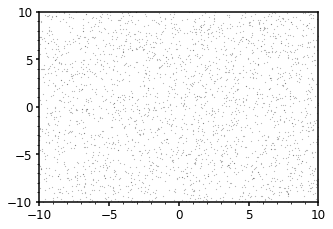

In [8]:
from astropy.io import fits
fits_image_filename = '/Users/mpetersen/Downloads/GSEz0snapshot.fits'

hdul = fits.open(fits_image_filename)
hdul.info()

plt.scatter(hdul[1].data['X'],hdul[1].data['VZ'],color='black',s=.01,alpha=1.)
plt.axis([-10,10,-10,10])



In [14]:
# add GSE

xpos = np.concatenate([xpos,hdul[1].data['X']])
ypos = np.concatenate([ypos,hdul[1].data['Y']])
zpos = np.concatenate([zpos,hdul[1].data['Z']])
xvel = np.concatenate([xvel,hdul[1].data['VX']])
yvel = np.concatenate([yvel,hdul[1].data['VY']])
zvel = np.concatenate([zvel,hdul[1].data['VZ']])


In [15]:
gse = np.concatenate([np.zeros(MWH.xpos.size),np.ones(hdul[1].data['VZ'].size)])


-1.5692141 1.5686401


[-400, 400, -400, 400]

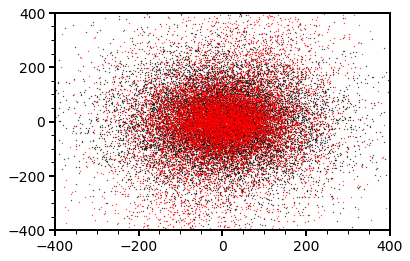

In [16]:

Lx = ypos*zvel - zpos*yvel
Ly = zpos*xvel - xpos*zvel
Lz = xpos*yvel - ypos*xvel

rad3 = np.sqrt(xpos*xpos+ypos*ypos+zpos*zpos)
rad2 = np.sqrt(xpos*xpos+ypos*ypos)
vr = (xpos*xvel + ypos*yvel + zpos*zvel)/rad3
vphi = -Lz/rad2


ltest = np.arctan2(ypos,xpos-8.16) + np.pi
btest = np.arccos(zpos/np.sqrt(xpos*xpos+ypos*ypos+zpos*zpos)) - np.pi/2.
print(np.nanmin(btest),np.nanmax(btest))
sdssflagall = interpolate_map(ltest,btest,xx,yy,bhbw,dens=5.0,verbose=False)


criteria = (gse==0) & (sdssflagall==1)
#plt.scatter(Lx[criteria][::10],Lz[criteria][::10],color='black',s=.1,alpha=1.)

Lx = (ypos+50.)*zvel - zpos*yvel
Ly = zpos*xvel - xpos*zvel
Lz = (xpos-4.)*yvel - (ypos+50.)*xvel
#plt.scatter(Lx[criteria][::10],Lz[criteria][::10],color='red',s=.1,alpha=.1)



#plt.scatter(ltest[criteria][::10],btest[criteria][::10],color='black',s=.1)

plt.scatter(vr[criteria][::10],vphi[criteria][::10],color='black',s=.1,alpha=1.)

rad3 = np.sqrt((xpos+20.)*(xpos+20.)+ypos*ypos+zpos*zpos)
vr = ((xpos+20.)*xvel + ypos*yvel + zpos*zvel)/rad3
rad3 = np.sqrt((xpos+20.)*(xpos+20.)+ypos*ypos)

vphi = -Lz/rad2


plt.scatter(vr[criteria][::10],vphi[criteria][::10],color='red',s=.1,alpha=1.)
plt.axis([-400,400,-400,400])



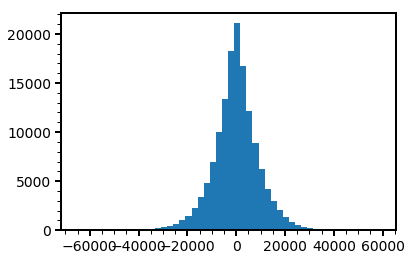

In [17]:
_ = plt.hist(Lz[criteria],bins=50)

[-100, 100, -100, 100]

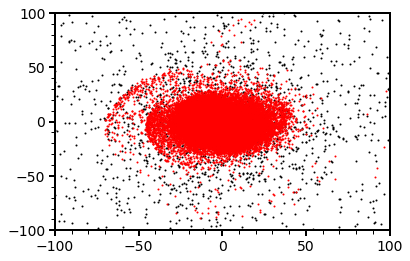

In [18]:
plt.scatter(xpos[::100],zpos[::100],color='black',s=1.)
plt.scatter(xpos[gse==1],zpos[gse==1],color='red',s=1.)


plt.axis([-100,100,-100,100])

In [19]:
rvals = np.sqrt(xpos*xpos + ypos*ypos + zpos*zpos)



In [20]:
w = np.where((rvals>50) & (rvals<100))[0]

print(np.nanmedian(xvel[w]),np.nanmedian(yvel[w]),np.nanmedian(zvel[w]))



0.9848497 -0.5088555 0.46023235


In [21]:
# put in Cartesian observables
rsun = [-8.21,0.,0.02]
vsun = [11.1, 244.24, 7.25]

#xpos += rsun[0]
#ypos += rsun[1]
#zpos += rsun[2]
#xvel += vsun[0]
#yvel += vsun[1]
#zvel += vsun[2]


In [22]:
import reflexmotion.galactic as gt
import reflexmotion.outlog as ol

In [23]:
dLj,dBj,radj,vrj,dmulj,dmubj = gt.galactic(xpos-rsun[0],\
#dLj,dBj,radj,vrj,dmulj,dmubj = jorge_galactic(xpos+rsun[0],\
                                           ypos-rsun[1],\
                                           zpos-rsun[2],\
                                           xvel-vsun[0],\
                                           yvel-vsun[1],\
                                           zvel-vsun[2],twopi=True)




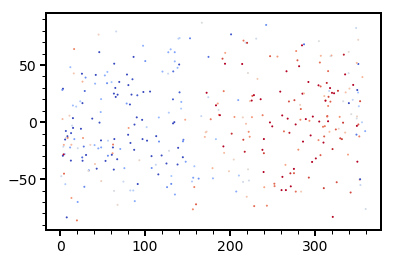

In [24]:
plt.scatter(dLj[::1000],dBj[::1000],color=cm.coolwarm((vrj[::1000]+200.)/400.,1.),s=1.)

In [25]:
xpos.size

350060

In [26]:
hdul[1].data['X'].size

50060

In [57]:
import glob
glob.glob('/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_s*35*heliocentric*')

['/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_s13_98_35k_heliocentric.txt',
 '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_s13_98_35k_heliocentric_old.txt',
 '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_s13rev_98_35k_heliocentric.txt',
 '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_s14_97_35k_heliocentric.txt',
 '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_s14rev_97_35k_heliocentric.txt',
 '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_s15_95_35k_heliocentric.txt',
 '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_s15rev_95_35k_heliocentric.txt',
 '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_s15rev_sample2_95_35k_heliocentric.txt',
 '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_s15rev_sample3_95_35k_heliocentric.txt',
 '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_s15rev_sample4_95_35k_heliocentric.txt']

15000


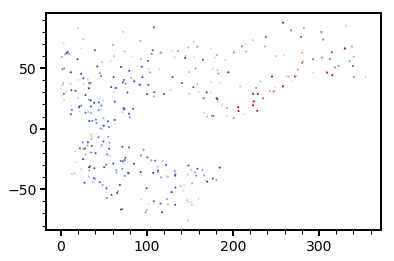

In [8]:
#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_s13_98_35k_heliocentric.txt'
#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_s14_97_35k_heliocentric.txt'
#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_s15_95_35k_heliocentric.txt'
outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_gse_0_35k_heliocentric.txt'




In = np.genfromtxt(outfile,skip_header=1)


x    = In[:,0]
y    = In[:,1]
z    = In[:,2]
vx   = In[:,3]
vy   = In[:,4]
vz   = In[:,5]

l    = In[:,6]
b    = In[:,7]
d    = In[:,8]
vr   = In[:,9]
dml  = In[:,10]
dmb  = In[:,11]

ed   = In[:,12]
evr  = In[:,13]
edml = In[:,14]
edmb = In[:,15]

ra   = In[:,16]
raq  = In[:,17]
sd   = In[:,18]

print(x.size)

plt.scatter(l[(sd==1) & (d>50)],b[(sd==1) & (d>50)],color=cm.coolwarm((vr[(sd==1) & (d>50)]+200.)/400.),s=1.)#'black',s=1.)

In [9]:
outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/model_s15_edr3_estimates.txt'


f = open(outfile,'w')


print('x [kpc]; y [kpc]; z [kpc]; vx [km/s]; vy [km/s]; vz [km/s]; \
     dL [deg]; dB [deg]; dist [kpc]; vlos [km/s]; dmul [marcsec/yr]; dmub [marcsec/yr]; \
      edist[kpc]; evlos [km/s]; edmul [marcsec/yr]; edmub [marcsec/yr]; \
      rapo [kpc]; rapo quality; sdss?',file=f)


for i in range(0,x.size):
    print(x[i],y[i],z[i],vx[i],vy[i],vz[i],\
          l[i],b[i],d[i],vr[i],dml[i],dmb[i],\
          ed[i],evr[i],0.5*edml[i],0.5*edmb[i],\
         0,1,sd[i].astype('int'),file=f)
    
    
f.close()



In [27]:

from scipy.interpolate import interp1d

def draw_sources(radk,numk,radj,nsources = 15000):
    """ draw sources from an input distribution to match a specified distribution
    
    inputs
    ---------
    radk     : 
    numk     :
    radj     :
    nsources :
    
    """
    # interpolate the input distribution
    
    spl = interp1d(numk,radk,'nearest')
    
    used = np.zeros(nsources,dtype='int')
    desdist = np.zeros(nsources)

    for i in range(0,nsources):
        #if i%1500==0:print(i)
        r = np.random.rand()
        desired_dist = spl(r)
        desdist[i] = desired_dist

        # set up a distance tolerance of 1%.
        # should this be converted to a heliocentric distance?
        w = np.where( (radj > 0.99*desired_dist) & (radj < 1.01*desired_dist))[0]

        # randomly select a star from the list
        t = np.random.choice(w)

        draws = 0
        while t in used:
            t = np.random.choice(w)
            draws+=1
            #if draws==w.size:
                #print('failure',w.size)
                #t = 1000000+i

        used[i] = t

    return used,desdist,spl



I = np.genfromtxt('../Shells/kgiantrange.txt')
radk = I[:,0]; numk = I[:,1]

#used,desdist,spl = draw_sources(radk,numk,radj[0:1000000],nsources = 15000)
used,desdist,spl = draw_sources(radk,numk,radj,nsources = 15000)



In [28]:
radj.size

350060

[]

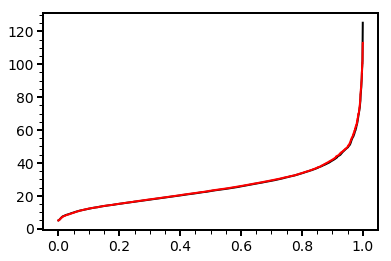

In [29]:
tstdist = np.linspace(0.,1.,1000)
plt.plot(tstdist,spl(tstdist),color='black')

tstdist = np.linspace(0.,1.,desdist.size)
plt.plot(tstdist,desdist[desdist.argsort()],color='red')

plt.plot()

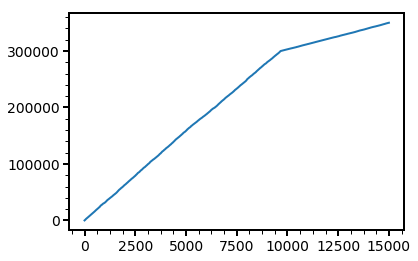

In [30]:
plt.plot(used[used.argsort()])

In [50]:
used.size

15000

In [49]:
print(np.nansum(gse[used]))

IndexError: index 74834 is out of bounds for axis 0 with size 15000

In [32]:

def jorge_galactic(x0,y0,z0,u0,v0,w0,twopi=True):
    
    rad = np.sqrt(x0**2+y0**2+z0**2)
    xphi= np.arctan2(y0,x0)
    xth = np.arccos(z0/rad)
    
    xur = np.zeros([3,x0.size])
    xur[0]= np.sin(xth)*np.cos(xphi)
    xur[1]= np.sin(xth)*np.sin(xphi)
    xur[2]= np.cos(xth)
         
    xuth = np.zeros([3,x0.size])
    xuth[0]= np.cos(xth)*np.cos(xphi)
    xuth[1]= np.cos(xth)*np.sin(xphi)
    xuth[2]=-np.sin(xth)

    xuphi = np.zeros([3,x0.size])
    xuphi[0]=-np.sin(xphi)
    xuphi[1]=+np.cos(xphi)
    xuphi[2]= 0.
    
    vr =    u0*  xur[0] + v0*  xur[1] + w0*  xur[2]
    vth=    u0* xuth[0] + v0* xuth[1] + w0* xuth[2]
    vphi=   u0*xuphi[0] + v0*xuphi[1] + w0*xuphi[2]
          
    vb= -vth
    
    # match the astropy output
    vl= vphi
         
    dk  =4.74057           #conversion from km/s
    par =1./rad             #arc sec --> rad in [kpc]
    dmul=vl / dk * par
    dmub=vb / dk * par

    f=np.pi/180.
    dB=np.arcsin(z0/rad)/f
    
    if twopi:
        dL=np.arctan(y0/x0)/f
        dL[(y0<0)&(x0>0.)] += 360.
        dL[(y0>0)&(x0<0.)] += 180.
        dL[(y0<0)&(x0<0.)] += 180.
    else:
        dL = np.arctan2(y0,x0)/f

    
    return dL,dB,rad,vr,dmul,dmub





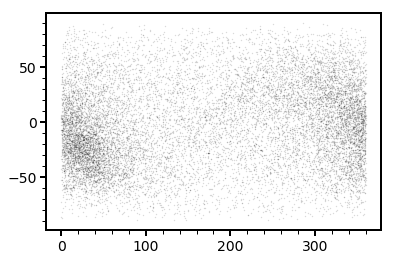

In [33]:
plt.scatter(dLj[used],dBj[used],color='black',s=0.1,alpha=0.2)

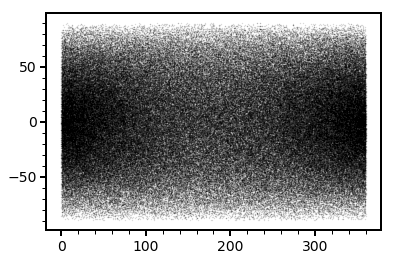

In [35]:
plt.scatter(dLj[gse==0],dBj[gse==0],color='black',s=0.1,alpha=0.2)

In [36]:
sdssflag = interpolate_map(dLj*(np.pi/180.),dBj*(np.pi/180.),xx,yy,bhbw,dens=5.0,verbose=False)

sdssflag.size,dLj.size

(350060, 350060)

In [37]:
plt.scatter(dLj[sdssflag==1][used],dBj[sdssflag==1][used],color='black',s=0.1,alpha=0.2)

IndexError: index 217102 is out of bounds for axis 0 with size 167203

In [38]:
used.size

15000

In [39]:


#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/erkal_2020_mock.txt'
#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/model_s14_erd3_estimates.txt'

#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/model_s13_erd3_estimates.txt'

#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/model_s15_erd3_estimates.txt'

#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_gse_0_35k_heliocentric.txt'
#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_gse_0_15k_all_heliocentric.txt'
outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_gse_0_15k_all_heliocentric.txt'
outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_gse_0_15k_all_heliocentric_noisy.txt'




f = open(outfile,'w')


print('x [kpc]; y [kpc]; z [kpc]; vx [km/s]; vy [km/s]; vz [km/s]; \
     dL [deg]; dB [deg]; dist [kpc]; vlos [km/s]; dmul [marcsec/yr]; dmub [marcsec/yr]; \
      edist[kpc]; evlos [km/s]; edmul [marcsec/yr]; edmub [marcsec/yr]; \
      rapo [kpc]; gse; sdss?; [dead]; [dead]; [dead]; corr ',file=f)

# x [kpc]; y [kpc]; z [kpc]; vx [km/s]; vy [km/s]; vz [km/s]; 
# l [deg]; b [deg]; dist [kpc]; vlos [km/s]; dmu_l [marcsec/yr]; dmu_b [marcsec/yr];      
# edist[kpc]; evlost [km/s]; edmu_l [marcsec/yr]; edmu_b [marcsec/yr];  
# [dead] ; [dead] ; [dead] ; Sgr Lambda [deg]; Sgr Beta [deg]; Belokurov Flag [bool]; corrcoef [-1:1]

# distance-dependent error factors
pmprefac=  0.013
pmprefac=  0.008 # test a down-weighting of uncertainties

pmprefac=  0.004 # edr3?

dprefac = 0.2
# set up blank rapo and rapoquality
rapo = np.ones(xpos.size)
rapoquality = np.zeros(xpos.size)


for i in used:

    print(np.round(xpos[i],2),\
          np.round(ypos[i],2),\
          np.round(zpos[i],2),\
          np.round(xvel[i],2),\
          np.round(yvel[i],2),\
          np.round(zvel[i],2),\
        np.round(dLj[i],2),\
          np.round(dBj[i],2),\
          np.round(radj[i]+np.random.normal(0,0.05*radj[i]),2),\
          np.round( vrj[i]+np.random.normal(0,dprefac*radj[i]),2),\
          np.round( dmulj[i]+np.random.normal(0,pmprefac*radj[i]),4),\
          np.round( dmubj[i]+np.random.normal(0,pmprefac*radj[i]),4),\
        np.round(0.05*radj[i],2),\
          np.round(np.abs(dprefac*radj[i]*np.random.normal()),2),\
          np.round(np.abs(pmprefac*radj[i]*np.random.normal()),4),\
          np.round(np.abs(pmprefac*radj[i]*np.random.normal()),4),\
        500.,\
          int(gse[i]),\
        int(sdssflag[i]),\
          0.0,0.0,0,0.0,\
          file=f)
    
f.close()









In [40]:


#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/erkal_2020_mock.txt'
#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/model_s14_erd3_estimates.txt'

#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/model_s13_erd3_estimates.txt'

#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/model_s15_erd3_estimates.txt'

#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_gse_0_35k_heliocentric.txt'
#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_gse_0_15k_all_heliocentric.txt'
outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_gse_0_15k_all_heliocentric.txt'
outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_gse_0_15k_all_heliocentric_noisefree.txt'




f = open(outfile,'w')


print('x [kpc]; y [kpc]; z [kpc]; vx [km/s]; vy [km/s]; vz [km/s]; \
     dL [deg]; dB [deg]; dist [kpc]; vlos [km/s]; dmul [marcsec/yr]; dmub [marcsec/yr]; \
      edist[kpc]; evlos [km/s]; edmul [marcsec/yr]; edmub [marcsec/yr]; \
      rapo [kpc]; gse; sdss?; [dead]; [dead]; [dead]; corr ',file=f)

# x [kpc]; y [kpc]; z [kpc]; vx [km/s]; vy [km/s]; vz [km/s]; 
# l [deg]; b [deg]; dist [kpc]; vlos [km/s]; dmu_l [marcsec/yr]; dmu_b [marcsec/yr];      
# edist[kpc]; evlost [km/s]; edmu_l [marcsec/yr]; edmu_b [marcsec/yr];  
# [dead] ; [dead] ; [dead] ; Sgr Lambda [deg]; Sgr Beta [deg]; Belokurov Flag [bool]; corrcoef [-1:1]

# distance-dependent error factors
pmprefac=  0.013
pmprefac=  0.008 # test a down-weighting of uncertainties

pmprefac=  0.004 # edr3?

dprefac = 0.2
# set up blank rapo and rapoquality
rapo = np.ones(xpos.size)
rapoquality = np.zeros(xpos.size)


for i in used:

    print(np.round(xpos[i],2),\
          np.round(ypos[i],2),\
          np.round(zpos[i],2),\
          np.round(xvel[i],2),\
          np.round(yvel[i],2),\
          np.round(zvel[i],2),\
        np.round(dLj[i],2),\
          np.round(dBj[i],2),\
          np.round(radj[i],2),\
          np.round( vrj[i],2),\
          np.round( dmulj[i],4),\
          np.round( dmubj[i],4),\
        np.round(0.*0.05*radj[i],2),\
          np.round(0.*np.abs(dprefac*radj[i]*np.random.normal()),2),\
          np.round(0.*np.abs(pmprefac*radj[i]*np.random.normal()),4),\
          np.round(0.*np.abs(pmprefac*radj[i]*np.random.normal()),4),\
        500.,\
          int(gse[i]),\
        int(sdssflag[i]),\
          0.0,0.0,0,0.0,\
          file=f)
    
f.close()










4439
15000


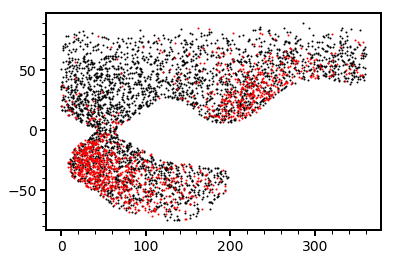

In [68]:

outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_gse_0_15k_all_heliocentric_noisy.txt'


In = np.genfromtxt(outfile,skip_header=1)


x    = In[:,0]
y    = In[:,1]
z    = In[:,2]
vx   = In[:,3]
vy   = In[:,4]
vz   = In[:,5]

l    = In[:,6]
b    = In[:,7]
d    = In[:,8]
vr   = In[:,9]
dml  = In[:,10]
dmb  = In[:,11]

ed   = In[:,12]
evr  = In[:,13]
edml = In[:,14]
edmb = In[:,15]

ra   = In[:,16]
gse  = In[:,17]
sd   = In[:,18]

r = np.sqrt(x*x+y*y+z*z)
print(len(np.where((sd==1) & (d>20))[0]))

dlim = r>20
plt.scatter(l[(sd==1) &(gse==0) & (dlim)],b[(sd==1) &(gse==0) & (dlim)],color='black',s=1.)
plt.scatter(l[(sd==1) &(gse==1) & (dlim)],b[(sd==1) &(gse==1) & (dlim)],color='red',s=1.)
print(sd.size)

#plt.scatter(d[(sd==1) &(gse==0) & (dlim)],dmb[(sd==1) &(gse==0) & (dlim)],color='black',s=1.)
#plt.scatter(d[(sd==1) &(gse==1) & (dlim)],dmb[(sd==1) &(gse==1) & (dlim)],color='red',s=1.)



#plt.scatter(l[(sd==1) & (d>50)],b[(sd==1) & (d>50)],color=cm.coolwarm((vr[(sd==1) & (d>50)]+200.)/400.),s=1.)#'black',s=1.)

In [74]:

print(np.nansum(gse[(sd==1) & (d>20)]))
print(np.nansum(gse[(sd>=0) & (r>20)])/len(gse[(sd>=0) & (r>20)]))
print(len(gse[(sd==1) & (r>20)]))




1321.0
0.2413833805476865
4296


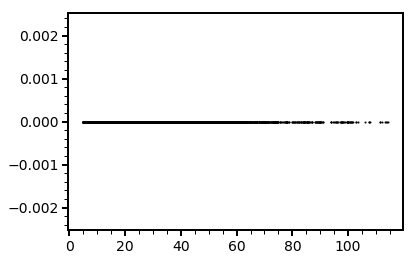

In [42]:
plt.scatter(d,edmb,color='black',s=1.)

In [ ]:


In = np.genfromtxt(outfile,skip_header=1)


x    = In[:,0]
y    = In[:,1]
z    = In[:,2]
vx   = In[:,3]
vy   = In[:,4]
vz   = In[:,5]

l    = In[:,6]
b    = In[:,7]
d    = In[:,8]
vr   = In[:,9]
dml  = In[:,10]
dmb  = In[:,11]

ed   = In[:,12]
evr  = In[:,13]
edml = In[:,14]
edmb = In[:,15]

ra   = In[:,16]
raq  = In[:,17]
sd   = In[:,18]

print(len(np.where((sd==1) & (d>50))[0]))

plt.scatter(l[(sd==1) & (d>50)],b[(sd==1) & (d>50)],color=cm.coolwarm((vr[(sd==1) & (d>50)]+200.)/400.),s=1.)#'black',s=1.)